In [1]:
%matplotlib inline
import os
import glob
import numpy
import rasterio
import geopandas
import rasterio.features
import matplotlib.pyplot as plt
from shapely.ops import unary_union
from shapely.geometry import Polygon

In [44]:
files = glob.glob('.\\waterbodies\\*.shp')
files = [x for x in files if 'water_mask' not in x]
example = '..\\hyp3_downloads\\p81f1048_10x2_2\\S1BB_20171224T070624_20180105T070624_VVP012_INT40_G_ueF_0A8B\\S1BB_20171224T070624_20180105T070624_VVP012_INT40_G_ueF_0A8B_dem.tif'

In [48]:
gdf = geopandas.GeoDataFrame()

for f in files:
    tmp_gdf = geopandas.read_file(f)
    tmp_gdf.crs = 'EPSG:4326'
    gdf = gdf.append(tmp_gdf)

gdf.crs = 'EPSG:4326'

<AxesSubplot:>

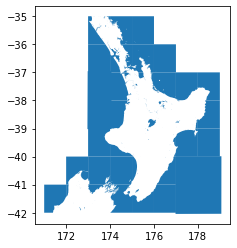

In [50]:
gdf_geometry = gdf.simplify(1e-12,preserve_topology=False)
gdf = geopandas.GeoDataFrame({'value':1,'geometry':gdf_geometry},crs='EPSG:4326')
gdf.to_file('waterbodies\\water_mask_combined.shp')
gdf.plot()

In [51]:
# Read in files
print('reading...')
gdf = geopandas.read_file('waterbodies\\water_mask_combined.shp')
raster_r = rasterio.open(example)
raster = raster_r.read()

# Reproject
if str(gdf.crs).upper() != str(raster_r.crs):
    gdf = gdf.to_crs(str(raster_r.crs))

# Clip
bounds = raster_r.bounds
bounding_box = Polygon([(bounds.left, bounds.top), (bounds.right, bounds.top), (bounds.right, bounds.bottom),
                        (bounds.left, bounds.bottom), (bounds.left, bounds.top)])
gdf = geopandas.clip(gdf, bounding_box)

# Save Corrected
gdf = gdf.dissolve(by='value')
gdf.to_file('waterbodies\\water_mask.shp')

reading...


rasterizing...


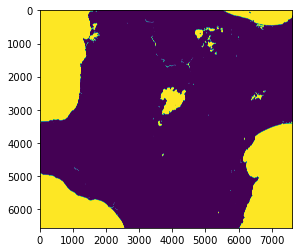

In [52]:
# Rasterize
gdf = geopandas.read_file('waterbodies\\water_mask.shp')
rasterized = rasterio.features.rasterize(
    [(x.geometry, 1) for i,x in gdf.iterrows()],
    out_shape=raster_r.shape,
    transform=raster_r.transform,
    fill=0,
    dtype=rasterio.uint8)

plt.imshow(rasterized)

In [53]:
# Write to file
profile = raster_r.profile
profile.update(dtype=rasterio.uint8, count=1, compress='lzw', nodata=0)
rasterized[rasterized < 1] = 0
with rasterio.open('waterbodies\\water_mask.tif', 'w', **profile) as out:
    out.write_band(1, rasterized)

writing...


In [60]:
# Delete intermediary data
files = [os.remove(x) for x in glob.glob('.\\waterbodies\\water_mask*') if 'tif' not in x]
# files = [x for x in files if 'water_mask' not in x]